# Dynamics of the echo state networks

The main goal of this notebook is to provide an insight on how an *echo states network* works. Moreover, the training of a toy example is performed in order to understand such procedure. The notebook is structured as follows:

+ [$\text{1. Terminology and key ideas}$](#Setting)
+ [$\text{2. Trajectories of the reservoir}$](#DynamicsReservoir)
    + [$\text{2.1 Forgetting properties}$](#ForgettingProperty)
        + [$\text{2.1.1 State forgetting property}$](#StateForgettingProperty)
        + [$\text{2.1.2 Input forgetting property}$](#InputForgettingProperty)
    + [$\text{2.2 Inhomogeneity vs Homogeneity of the reservoir}$](#Homogeneity)
        + [$\text{2.2.1 Inhomogeneous reservoir}$](#Inhomogeneous)
        + [$\text{2.2.2 Homogeneous reservoir}$](#Homogeneous)
            + [$\text{Fully-connected reservoir with the same weights}$](#FullyConnected)
            + [$\text{Fully-connected reservoir with different weights}$](#FullyConnectedDifWeights)
            + [$\text{Non Fully-connected reservoir with different weights}$](#NonFullyConnected)
    + [$\text{2.3 Input's influence on reservoir's dynamics}$](#InputvsReservoir) 
        + [$\text{Periodic input}$](#PeriodicInput)
        + [$\text{Constant input}$](#ConstantInput)
        + [$\text{Combination of sines and cosines with different periods}$](#SinesCosines)
        + [$\text{Input randomly choosen from [-1,-1]}$](#RandomUnif)
        + [$\text{Periodic sparkling signal}$](#PeriodicSparkling)
        + [$\text{Random sparkling signal}$](#RandomSparkling)
+ [$\text{3. Training a toy problem}$](#ToyProblem)
    + [$\text{3.1 Learning an output with no feedback: input and output related}$](#Related)
        + [$\text{3.1.1 Definition of the parameters of the network}$](#Ex1Params)
        + [$\text{3.1.2 Training}$](#Ex1Train)
        + [$\text{3.1.3 Testing}$](#Ex1Test)
    + [$\text{3.2 Learning an output with no feedback: input and output non-related}$](#NonRelated)
        + [$\text{3.2.1 Definition of the parameters of the network}$](#Ex2Params)
        + [$\text{3.2.2 Training}$](#Ex2Train)
        + [$\text{3.2.3 Testing}$](#Ex2Test)
        


# 1. Terminology and key ideas <a name="Setting" ></a>

The most common approach when dealing with sequential series is to use recurrent neural networks (RNN) due to its capacity of storing information about the past. However, its main downside is the exploding or vanishing gradient encountered when performing the backpropagation. In addition, all the matrices giving the connections between the different elements have to be learnt. In order to overcome such difficulties, the so called *echo state networks* are introduced. 

The main goal of this notebook is to provide an intuition of the idea behind echo states. Recall that *echo states* mean that the internal states can be thought of as an "echo" of the past. In other words, it means that the internal states are univocally determined by the input and, if it has feedback, also by the previous outputs  (see the memory for a formal definition of *echo states*). The network we are going to be dealing with displays the following topology:

<img src="Images/EchoStateBasic.png" alt="EchoStateBasic" width="300"/>

where
* $W^\text{in}\in M(\mathbb{R})_{N\times K}$, gives the connection weights from the input units to the internal units. That is, $W^\text{in}_{i,j}$ gives the weight of the connection from the $j$-th input unit to the $i$-th internal unit.
* $W\in M(\mathbb{R})_{N\times N}$, gives the connection weights between the different internal units.
* $W^\text{out}\in M(\mathbb{R})_{L\times N}$, gives the connection wights from internal units to output units. 
* $W^\text{back}\in M(\mathbb{R})_{N\times L}$, gives the connection weights from the output units to the internal units.

and where
* $u(n)=(u_1(n),u_2(n),...,u_K(n)))$ is a $K$-dimensional vector giving the input units at time $n$.
* $x(n)=(x_1(n),x_2(n),...,x_N(n)))$ is an $N$-dimensional vector giving the internal units at time $n$. It is also called *internal state* or just *state*.
* $y(n)=(y_1(n),y_2(n),...,y_L(n)))$ is an $L$-dimensional vector giving the output units at time $n$.

**Notice that the input, the internal states and the outputs are time series.**

Therefore, an unrolled version of the previous image would be the following

<img src="Images/EchoStateBasic2.png" alt="EchoStateBasic2" width="300"/>


From the set of vectors, $x(n)$ is going to be updated at each time step as follows

$$
x(n+1)=f(W^\text{in} u(n+1)+Wx(n)+W^\text{back}y(n)),
$$ 

where $f$ is the activation function. On the other hand, the value of the output $y$ is going to be computed as

$$
y(n+1)=f^\text{out}\left(W^\text{out}x(n+1)\right),
$$

where $f^\text{out}$ is the activation function. In all the experiments we are going to perform along the project, we are going to take $f=f^\text{out}=\tanh$, which is applied component-wise.

**Observation**: as stated in the memory of the project, the existence of echo states guarantees that the only weights to be learnt are $W^\text{out}$, which implies that performing a linear regression is enough. In addition, each component of the output $y$ is going to be a linear combination of the trajectories of the states. That is,

$$
y_i = f^\text{out}\left(\sum_{j=1}^N W_{i,j}^\text{out}x_j\right) \quad \text{ for all i $\in \{1,...,L\}$}.
$$

This implies that the output has to be contained in the subspace generated by the states' trajectories. Thus, being able of getting a wide variety of states' trajectories is key in order to being able of generating the desired output. In other words, the set of trajectories of the internal states has to be a *reservoir of dynamics*. That is the reason why the graph given by $W$ is usually called *reservoir*. In addition, since the nodes of the reservoir are time series, we usually talk about the dynamics of the nodes.


# 2. Dynamics of the reservoir <a name="DynamicsReservoir" ></a>

In this section, we are going to illustrate some of the properties of the echo state networks as well as to provide an insight on the dynamics of the trajectories of the internal states of the reservoir.

Let us begin by defining a class object to construct the network. This class is going to evolve along this and the following notebooks since we will be adding attributes and methods as we need them.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy.linalg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
class Network():
    def __init__(self, u = None, W_in = None, W = None, W_back = None, initial_state = None, T = None):
        self.u = u
        self.W_in = W_in
        self.W = W
        self.T = T
        self.W_back = W_back 
        self.initial_state = initial_state

## 2.1 Forgetting properties <a name="ForgettingProperty" ></a>

In this section, we will verify that the state and input forgetting properties are actually satisfied.

### 2.1.1 State forgetting property <a name="StateForgettingProperty" ></a>

In this section, we are going to check the *state forgetting* property, which states that the dynamics of each node does not depend at all on the initial state. That is, the initial state of the reservoir will only influence the dynamics of the nodes on the first time steps and, after some time, the trajectories will converge to the same one. <br>
**Note**: the state forgetting property is satisfied as long as the *standard compactness conditions* are satisfied.

Let us begin by defining the different parts of the network.

<ins>**INPUT**</ins>

Let us consider the following unidimensional input

$$
u(n) = \sin\left(\frac{n}{5}\right),
$$

which is a periodic function of period $P=10\pi$. This vector will be defined for 100 time steps.

In [3]:
Network = Network() #instance of the class

Network.T = np.arange(100) #time steps
Network.u = np.sin(Network.T/5) #input

<ins>**RESERVOIR**</ins>

The reservoir we are going to use consists of 100 nodes randomly connected using weights of 0, 0.4 and -0.4 with probabilities of 0.95, 0.025 and 0.025 respectively. The reservoir is going to be constructed by defining its adjacency matrix, denoted as $W$.

In [4]:
Network.W = np.zeros([100,100]) #adjacency matrix

for i in np.arange(100):
    for j in np.arange(100):
        p = np.random.uniform()
        if 0<= p <0.025:
            Network.W[i,j] = 0.4            
            
        elif 0.025 <= p <0.05:
            Network.W[i,j] = -0.4


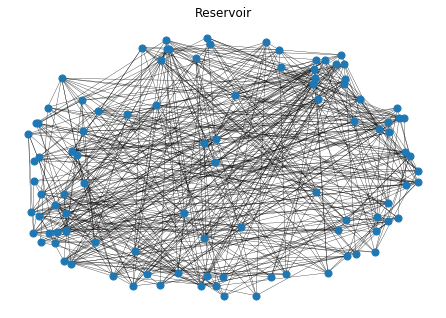

The reservoir has 100 nodes and 489 edges


In [5]:
G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

<ins>**OTHER PARAMETERS**</ins>

Let us determine the other parameters of the network. The input weights are going to take values 1 and -1 with equal probability. Recall that we are not considering feedback weights.

In [5]:
Network.W_in = random.choices([-1,1], k=100)
Network.W_in = np.asarray(Network.W_in)

<ins>**COMPUTE THE TRAJECTORIES**</ins>

Since we are not considering feedback connections, the formula for updating the states is

$$
x(n+1)=f(W^\text{in}u(n+1)+Wx(n)).
$$

We are going to take $f=\tanh$. Since we want to check the forgetting state property, we are going to initialize the reservoir in three different ways: zero, one and with random values uniformly chosen on [-1,1].  Then, we will let the reservoir evolve for each of them.

In [6]:
initial_state_1 = np.ones(100)
initial_state_2 = np.zeros(100)
initial_state_3 = np.random.uniform(low=-1, high=1, size=100)

In [7]:
#trajectories_state[i] is the matrix of the trajectories corresponding to initial_state_i.
#Its columns are the nodes and its rows the time.

trajectories_state = [initial_state_1, initial_state_2, initial_state_3]
i=0

for initial_state in [initial_state_1, initial_state_2, initial_state_3]:
    x_prev = initial_state
        
    for n in Network.T:
        x = np.tanh(Network.W_in*Network.u[n]+np.dot(Network.W,x_prev))
        trajectories_state[i] = np.vstack((trajectories_state[i],x))
        x_prev = x
        
    i += 1
        

In [8]:
#100 nodes and 101 time steps (since we are taking into account the initial one)
for i in np.arange(3):
    print(trajectories_state[i].shape)

(101, 100)
(101, 100)
(101, 100)


Let us now plot the trajectories for five randomly selected nodes considering the three different initial states.

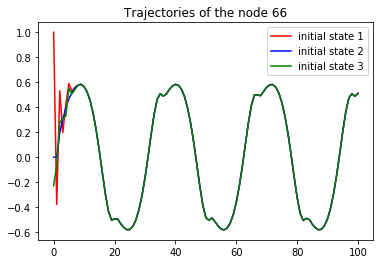

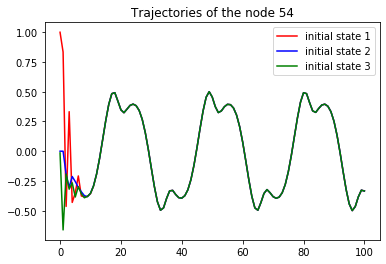

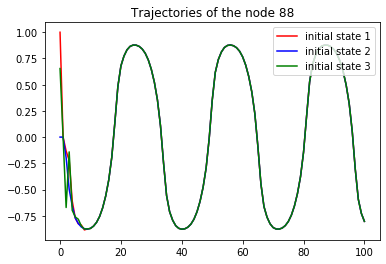

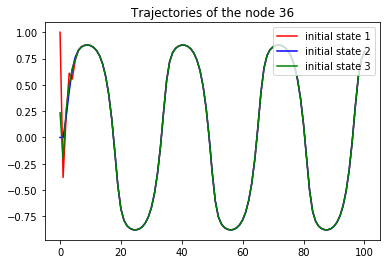

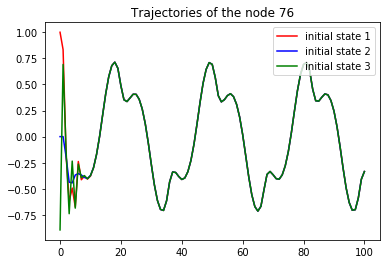

In [9]:
nodes_to_plot = random.sample(range(100),5) #select 5 random nodes
t = np.arange(101) #time steps

for node in nodes_to_plot:
    plt.plot(t, trajectories_state[0][:,node], 'r', label="initial state 1")  
    plt.plot(t, trajectories_state[1][:,node], 'b', label="initial state 2")  
    plt.plot(t, trajectories_state[2][:,node], 'g', label="initial state 3") 
    plt.legend(loc='upper right')
    plt.title("Trajectories of the node {}".format(node))
    plt.show()


By looking at the above trajectories, we can see the *state forgetting* property. That is, for each node, we observe how the initial condition influentiates the begining of the trajectories but, after few time steps, all of them converge to the same one. On the other hand, it is also worth noticing the fact that, although the trajectories of the nodes are different, they are periodic with the same periodicity as the input function $u$. The reason is the fact that the value of each node is computed as a linear combination of the input function. **Therefore, this implies a more general idea: since the values of the nodes are computed as a linear combination of the input (and themselves), some features of the dynamics of the nodes will be determined by the dynamics of the input.** That is, if the input is periodic, the trajectories of the nodes will be periodic with the same periodicity; if the input is constant, the trajectories of the nodes will also be constant; if the input is random, the trajectories of the nodes will also be random. In fact, in [Section 1.3](#InputvsReservoir), some experiments will be carried out in order to see the influence of the input on the reservoir.

### 2.1.2 Input forgetting property <a name="InputForgettingProperty" ></a>

In this section, we are going to check the input forgetting property, which states that the dynamics of each node does not depend at all on the initial values of the input. That is, the initial value of the input will only influence the dynamics of the nodes on the first time steps and, after some time, the trajectories will converge to the same one.
Note: the input forgetting property is satisfied as long as the standard compactness conditions are satisfied.

We are going to use the same network as in [Section 2.1.1](#StateForgettingProperty).

Let us begin by defining two types of input: the original one along with another one obtained by adding some random noise at the first time steps.

In [15]:
T = np.arange(100) #time steps
original_input = np.sin(T/5) #original input
fluct_input = np.sin(T/5)
for i in np.arange(20):
    fluct_input[i] = fluct_input[i]+np.random.uniform(low=-1, high=1)

In [16]:
#trajectories_state[0] is the matrix of the trajectories corresponding to the original input
#trajectories_state[1] is the matrix of the trajectories corresponding to the modified input
#Its columns are the nodes and its rows the time.

trajectories_state = [initial_state_2, initial_state_2]
i=0

for u in [original_input, fluct_input]:
    x_prev = initial_state_2 #initialize always at 0
        
    for n in T:
        x = np.tanh(Network.W_in*u[n]+np.dot(Network.W,x_prev))
        trajectories_state[i] = np.vstack((trajectories_state[i],x))
        x_prev = x
        
    i += 1
        

In [18]:
#100 nodes and 101 time steps (since we are taking into account the initial one)
for i in np.arange(2):
    print(trajectories_state[i].shape)

(101, 100)
(101, 100)


Let us now plot the trajectories for five randomly selected nodes considering the two different inputs.

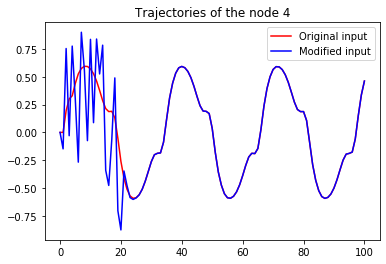

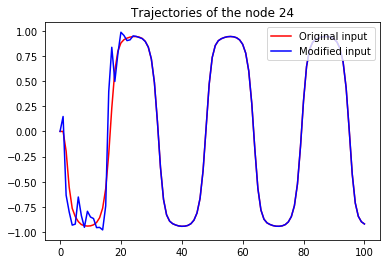

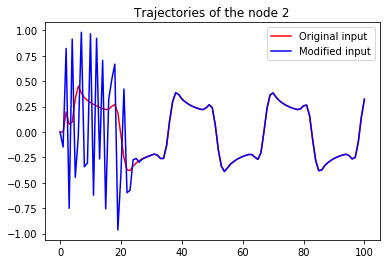

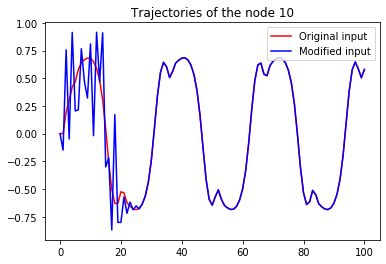

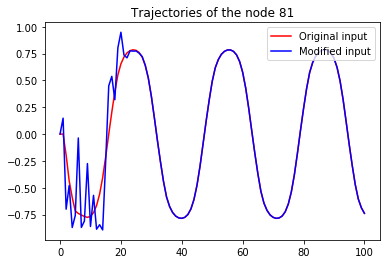

In [19]:
nodes_to_plot = random.sample(range(100),5) #select 5 random nodes
t = np.arange(101) #time steps

for node in nodes_to_plot:
    plt.plot(t, trajectories_state[0][:,node], 'r', label="Original input")  
    plt.plot(t, trajectories_state[1][:,node], 'b', label="Modified input")  
    plt.legend(loc='upper right')
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

Notice that the first time steps are quite different but, after some points, both trajectories converge to the same one. Therefore, the influence of the first points fades out. The input forgetting property is satisfied.

<ins>**ABOUT THE ADJACENCY MATRIX**</ins>

We have seen that this network satisfies the state forgetting property. Therefore, it has echo states. Recall that we have a proposition saying that if $\sigma_\text{max}<1$, then the network has echo states for all inputs **u** and for all states **x**, **x'**$\in [-1,1]$. However, this statement is quite restrictive since there are cases were $\sigma_\text{max}>1$ and it still has echo states. In fact, this is the case of our example.

In [10]:
_,s,_ = scipy.linalg.svd(Network.W)
s[0]

1.7897584256345558

## 2.2 Inhomogeneity vs Homogeneity of the reservoir <a name="Homogeneity" ></a>

In order to obtain a network capable of learning the desired output, the nodes of the reservoir are required to have different dynamics. This could be achieved by defining *inhomogeneous* reservoirs. In this section, we are going to compare the dynamics of the nodes depending on whether the reservoir is homogeneous or inhomogeneous.

### 2.2.1 Inhomogeneous reservoir <a name="Inhomogeneous" ></a>

Notice that, in [Section 2.1](#StateForgettingProperty), we already constructed an inhomogeneous reservoir. Let us now plot the trajectories of five randomly selected nodes from that reservoir. 

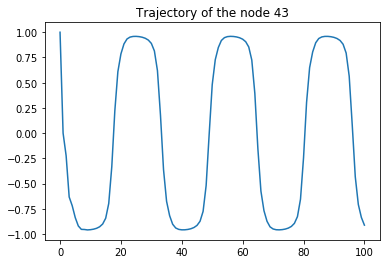

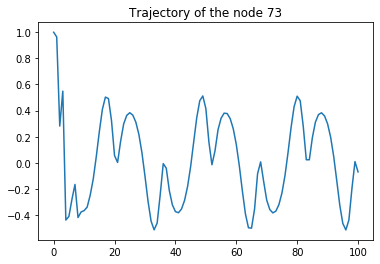

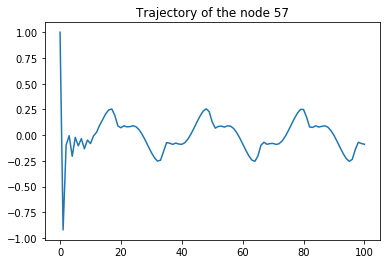

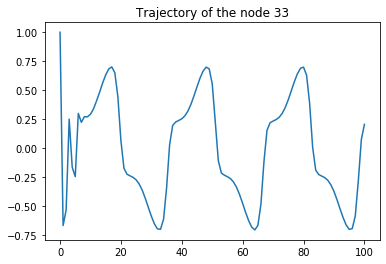

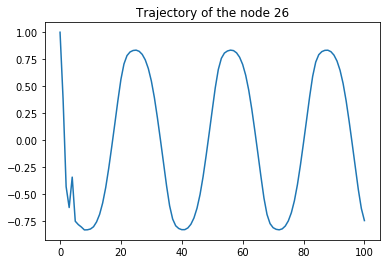

In [13]:
nodes_to_plot = random.sample(range(100),5) #select 5 random nodes
t = np.arange(101) #time steps

for node in nodes_to_plot:
    plt.plot(t, trajectories_state[0][:,node])  
    plt.title("Trajectory of the node {}".format(node))
    plt.show()

### 2.2.2 Homogeneous reservoir <a name="Homogeneous" ></a>

We are going to analyze three different homogeneous reservoirs: [fully-connected with the same weights](#FullyConnected), [fully-connected with different weights](#FullyConnectedDifWeights) and [non fully-connected with different weights](#NonFullyConnected).

### Fully-connected reservoir with the same weights <a name="FullyConnected" ></a>

Let us now define an homogeneous reservoir. In particular, we are going to take a fully-connected graph were each edge has the same weight. The weights are chosen so as to get a maximum singular value  below 1, which guarantees echo states.

In [14]:
Network_homogeneous = Network

In [19]:
Network_homogeneous.W = 1/101*np.ones([100,100]) #adjacency matrix
_,s,_ = scipy.linalg.svd(Network_homogeneous.W)
s[0]

0.9900990099009901

In [18]:
Network_homogeneous.initial_state = np.ones(100) #irrelevant due to state forgetting property

In [20]:
trajectories_state = Network_homogeneous.initial_state
x_prev = initial_state

for n in Network_homogeneous.T:
    x = np.tanh(Network_homogeneous.W_in*Network_homogeneous.u[n]+np.dot(Network_homogeneous.W,x_prev))
    trajectories_state = np.vstack((trajectories_state,x))
    x_prev = x


We are now going to plot the trajectories of the same above nodes.

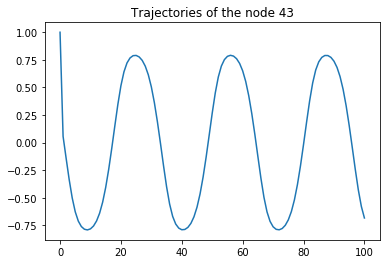

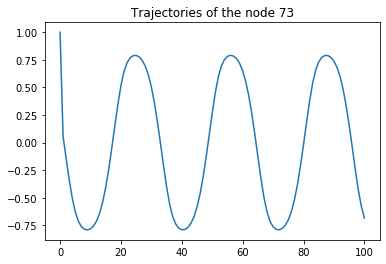

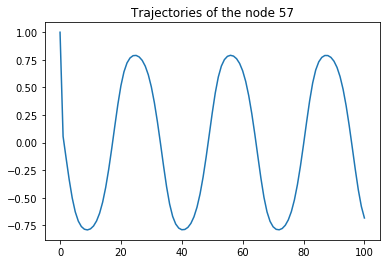

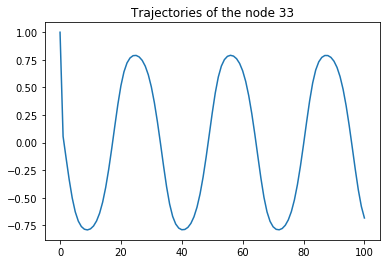

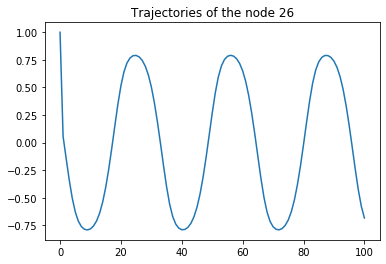

In [21]:
for node in nodes_to_plot:
    plt.plot(t, trajectories_state[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

As one would expect, when taking a fully-connected reservoir with the same weights, the dynamics of the different nodes are identical. 

### Fully-connected reservoir with different weights <a name="FullyConnectedDifWeights" ></a>

Let us now define a fully-connected reservoir whose weights are uniformly sampled from [-1/12,1/12]. The factor of 1/12 is needed to get a maximum singular value below 1.

In [24]:
Network_homogeneous2 = Network_homogeneous

In [27]:
Network_homogeneous2.W = 1/12*np.random.uniform(low=-1, high=1, size=100*100)#adjacency matrix
Network_homogeneous2.W = np.resize(Network_homogeneous2.W,(100,100))
_,s,_ = scipy.linalg.svd(Network_homogeneous.W)
s[0]

0.9068244285169779

In [28]:
trajectories_state = Network_homogeneous2.initial_state
x_prev = initial_state

for n in Network_homogeneous2.T:
    x = np.tanh(Network_homogeneous2.W_in*Network_homogeneous2.u[n]+np.dot(Network_homogeneous2.W,x_prev))
    trajectories_state = np.vstack((trajectories_state,x))
    x_prev = x

Let us now plot the trajectories for the same nodes as before.

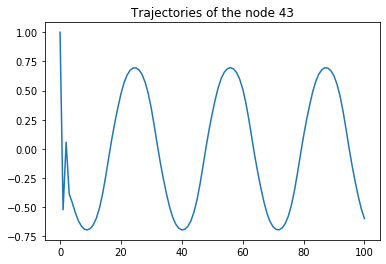

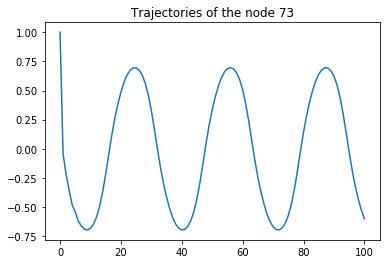

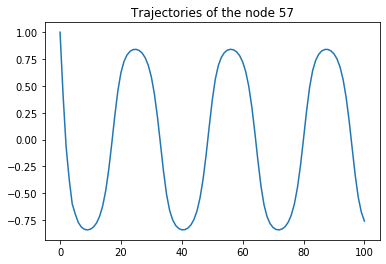

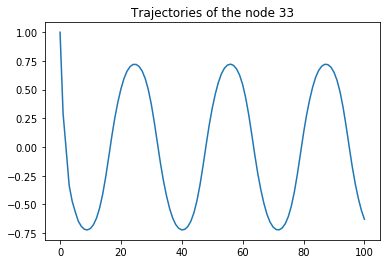

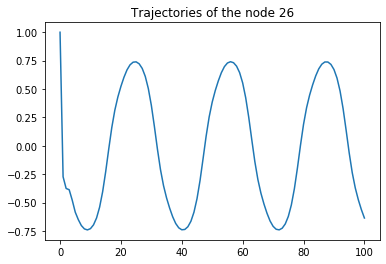

In [29]:
for node in nodes_to_plot:
    plt.plot(t, trajectories_state[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

We can see that they are still quite similar.

### Non Fully-connected reservoir with different weights <a name="NonFullyConnected" ></a>

Let us now define a reservoir whose weights are 0 and -1/14 and 1/14 with probabilities 0.5, 0.25 and 0.25. The factor 1/14 is to get a maximum singular value below 1, which assures echo states. Notice that around 50% of the edges are missing.

In [30]:
Network_homogeneous3 = Network_homogeneous

In [179]:
Network_homogeneous3.W = random.choices([-1/14,1/14], k=100*100) #adjacency matrix
Network_homogeneous3.W=np.reshape(Network_homogeneous3.W,(100,100))
#Network_homogeneous3.W = Network_homogeneous3.W 
         
for i in np.arange(100):
    for j in np.arange(100):
        p = np.random.uniform()
        if 0<= p <0.5:
            Network_homogeneous3.W[i,j] = 0
        

In [180]:
_,s,_ = scipy.linalg.svd(Network_homogeneous3.W)
s[0]

0.9651635313870006

In [181]:
trajectories_state = Network_homogeneous3.initial_state
x_prev = initial_state

for n in Network_homogeneous3.T:
    x = np.tanh(Network_homogeneous3.W_in*Network_homogeneous3.u[n]+np.dot(Network_homogeneous3.W,x_prev))
    trajectories_state = np.vstack((trajectories_state,x))
    x_prev = x

Let us now plot the trajectories for the same nodes as before.

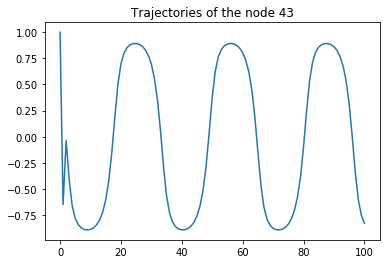

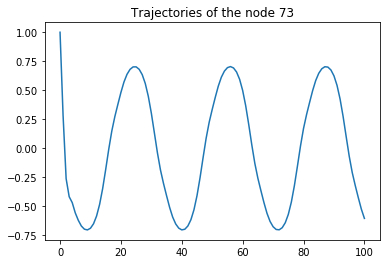

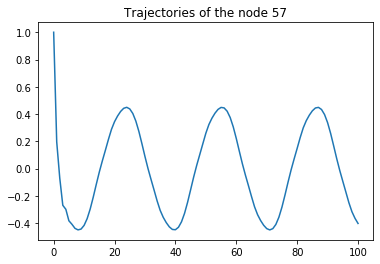

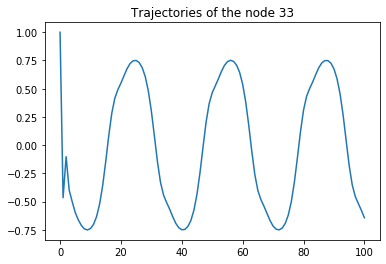

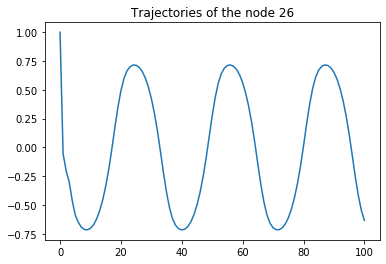

In [182]:
for node in nodes_to_plot:
    plt.plot(t, trajectories_state[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

With this examples we illustrate the fact that homogeneous reservoirs result on a lack of diversity in the nodes' dynamics. Moreover, we observe that the inhomogeneity is achieved by sparse reservoirs, since sparsity encourages different dynamics.

## 2.3 Input's influence on reservoir's dynamics <a name="InputvsReservoir" ></a>

In the experiment performed in [Section 2.1](#StateForgettingProperty), we saw that, if the input is periodic, then the trajectories of the nodes of the reservoir are also periodic. In this section, we are going to analyze the behavior of the nodes for different types of inputs in order to see at which extent the dynamics of the reservoir are influenciated by the dynamics of the input. In order to do so, the trajectories of ten randomly selected nodes of the reservoir are going to be plotted.

The experiments carried out will regard 6 different inputs: [periodic](#PeriodicInput), [constant](#ConstantInput), [combination of sines and cosines with different periods](#SinesCosines), [randomly chosen from [-1,1]](#RandomUnif), a [periodic sparkling signal](#PeriodicSparkling) and a [random sparkling signal](#RandomSparkling).

For all the experiments performed in this section, the same network is used. Such network is the one defined in [Section 2.1](#StateForgettingProperty). That is, on the one hand, a reservoir of 100 nodes with weights 0, 0.4 and -0.4 with probabilites 0.95, 0.025 and 0.025 respectively. On the other hand, $W^\text{in}$ takes values -1 and 1 with the same probability. 

Although this network is already defined, we are going to clean all the variables defined so far and we will define the network again.

In [1]:
class Network():
    def __init__(self, u = None, W_in = None, W = None, W_back = None, initial_state = None, T = None):
        self.u = u
        self.W_in = W_in
        self.W = W
        self.T = T
        self.W_back = W_back 
        self.initial_state = initial_state

In [3]:
Network = Network()

Network.T = np.arange(300) #300 time steps
Network.initial_state = np.ones(100)
Network.n_max = len(Network.T)-1

Network.W_in = random.choices([-1,1], k=100)
Network.W_in = np.asarray(Network.W_in)


########################
# Reservoir
########################

Network.W = np.zeros([100,100]) #adjacency matrix

for i in np.arange(100):
    for j in np.arange(100):
        p = np.random.uniform()
        if 0<= p <0.025:
            Network.W[i,j] = 0.4
                        
        elif 0.025 <= p <0.05:
            Network.W[i,j] = -0.4
            

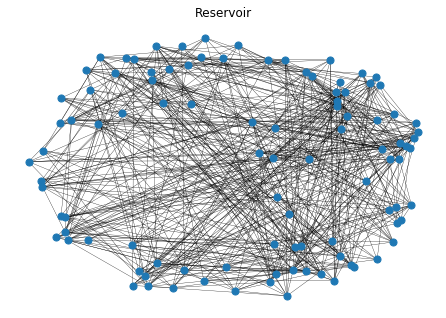

The reservoir has 100 nodes and 496 edges


In [4]:
G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

Notice that, although the reservoir is generated in the same way as in [Section 2.1](#StateForgettingProperty), the generation is random. Therefore, both reservoirs are not identical. In particular, notice that the number of edges obtained in both cases is different.

Now, we will proceed to the computation of the trajectories of the nodes of the reservoir for the 6 different inputs.

### Periodic input <a name="PeriodicInput" ></a>

This experiment has already been done in [Section 2.1](#StateForgettingProperty).

### Constant input <a name="ConstantInput" ></a>

If the input is constant, we expect the trajectories of the nodes to be constant, since the nodes are going to be linear combinations of constant values. However, the constant value for each node may be different. 

In [4]:
Network.u = np.ones(len(Network.T))

In [5]:
########################
# Trajectories
########################  
    
Network.trajectories = Network.initial_state
x_prev = Network.initial_state

for n in Network.T:
    x = np.tanh(Network.W_in*Network.u[n]+np.dot(Network.W,x_prev))
    Network.trajectories = np.vstack((Network.trajectories,x))
    x_prev = x

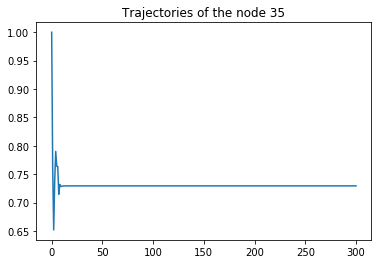

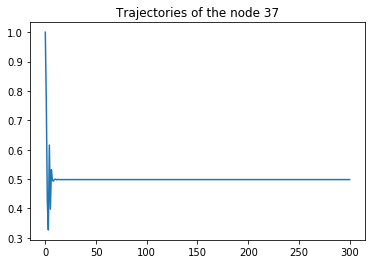

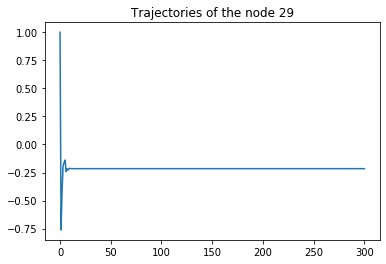

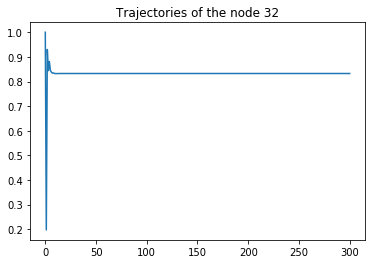

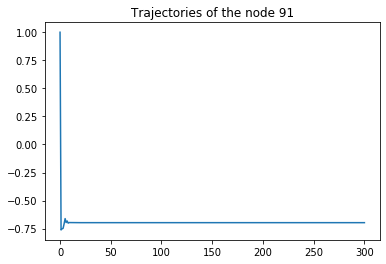

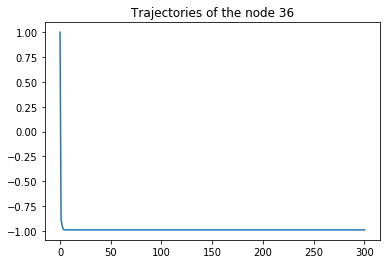

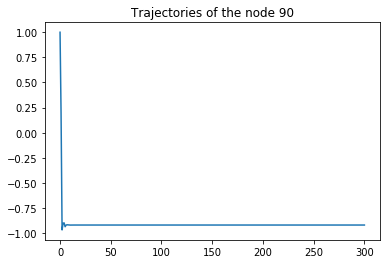

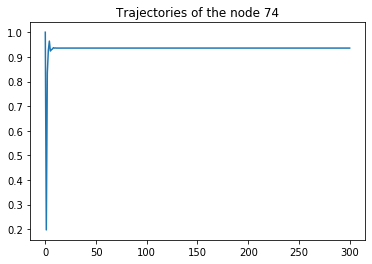

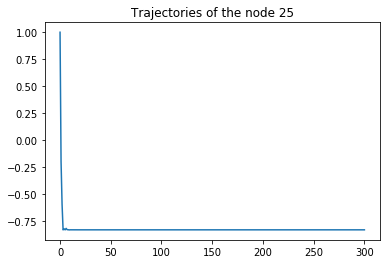

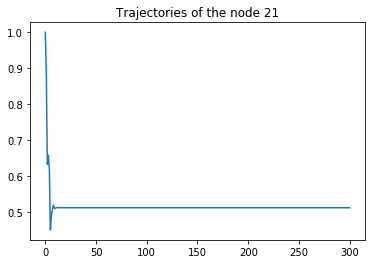

In [7]:
nodes_to_plot = random.sample(range(100),10) #select 10 random nodes
t = np.arange(len(Network.T)+1) #time steps
for node in nodes_to_plot:
    plt.plot(t, Network.trajectories[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

### Combination of sines and cosines with different periods <a name="SinesCosines" ></a>

Let us now see the dynamics of the reservoir when the input is constructed as a combination of sines and cosines. In particular, we are going to take

$$
u(n) = \frac{1}{20}\left[ \sin\left(\frac{n}{10}\right) + 7\sin\left(\frac{n}{3}\right) + \sin(3n)\cos(n)\right]
$$

In [8]:
Network.u = (np.sin(Network.T/10)+7*np.sin(Network.T/3)+np.sin(3*Network.T)*np.cos(Network.T))/20

Let us first plot the signal.

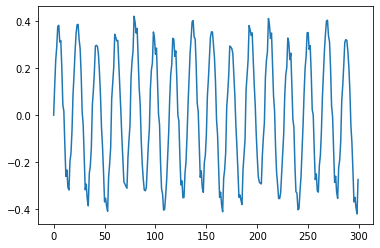

In [10]:
plt.plot(Network.T, Network.u)

In [11]:
########################
# Trajectories
########################  
    
Network.trajectories = Network.initial_state
x_prev = Network.initial_state

for n in Network.T:
    x = np.tanh(Network.W_in*Network.u[n]+np.dot(Network.W,x_prev))
    Network.trajectories = np.vstack((Network.trajectories,x))
    x_prev = x

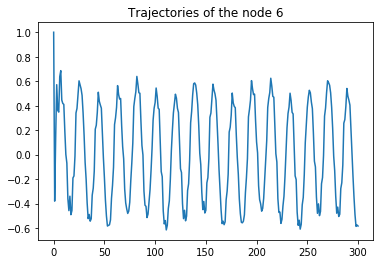

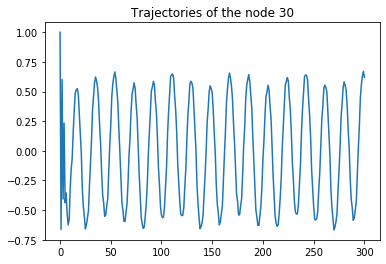

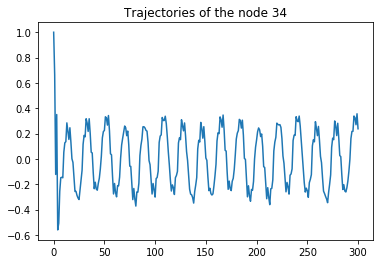

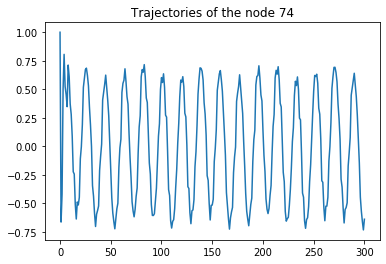

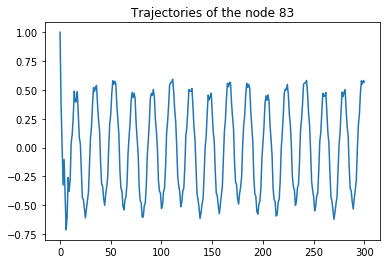

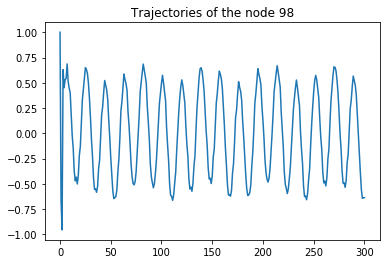

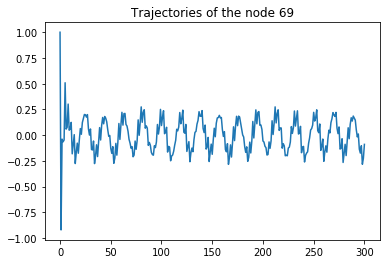

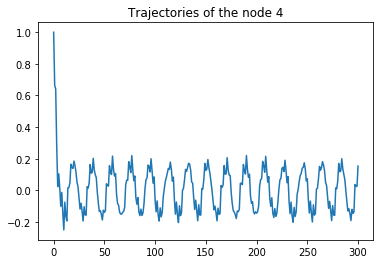

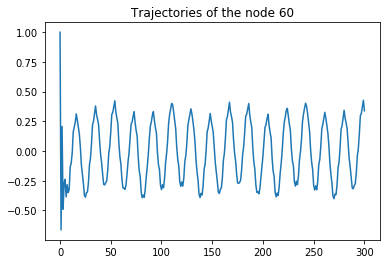

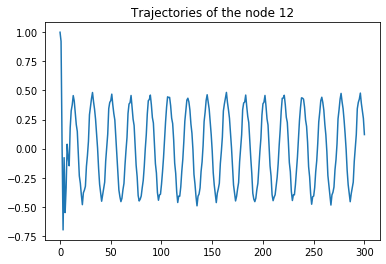

In [12]:
nodes_to_plot = random.sample(range(100),10) #select 10 random nodes
t = np.arange(len(Network.T)+1) #time steps
for node in nodes_to_plot:
    plt.plot(t, Network.trajectories[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

We see that the behavior is quite unpredictable.

### Input randomly choosen from [-1,-1] <a name="RandomUnif" ></a>

Take a random input uniformly samples from [-1,1]. Then, the trajectories of the nodes are expected to display a similar random behavior.

In [18]:
Network.u = np.random.uniform(low=-1, high=1, size = 300)

In [20]:
########################
# Trajectories
########################  
    
Network.trajectories = Network.initial_state
x_prev = Network.initial_state

for n in Network.T:
    x = np.tanh(Network.W_in*Network.u[n]+np.dot(Network.W,x_prev))
    Network.trajectories = np.vstack((Network.trajectories,x))
    x_prev = x

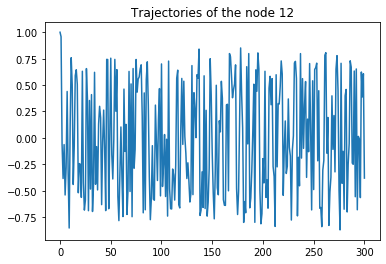

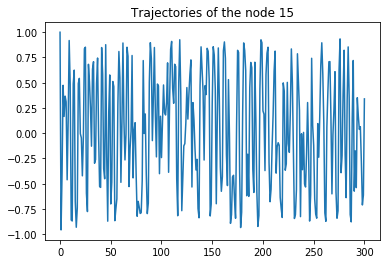

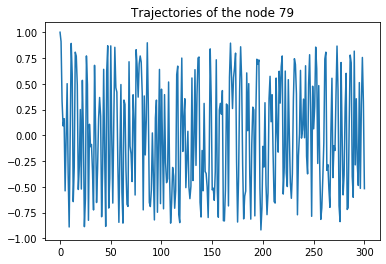

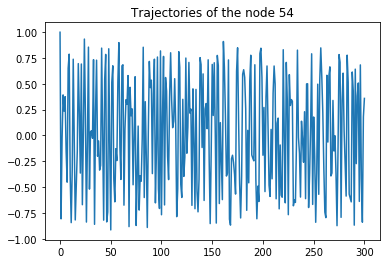

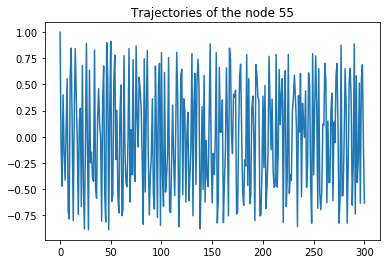

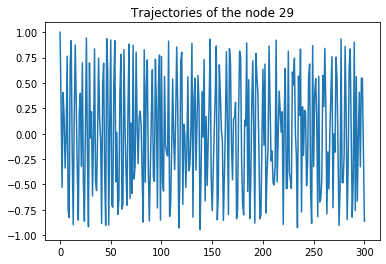

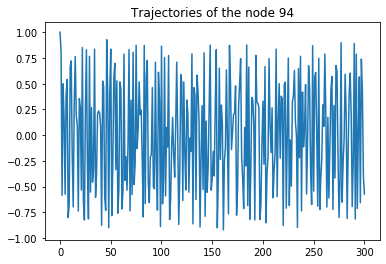

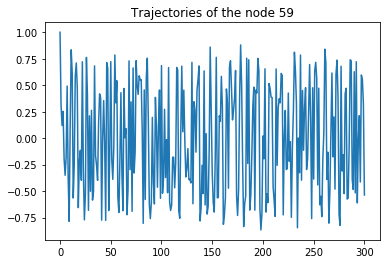

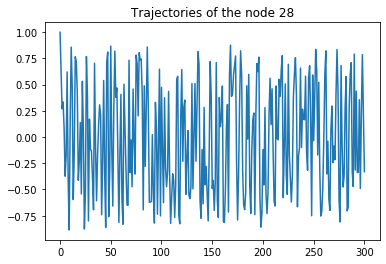

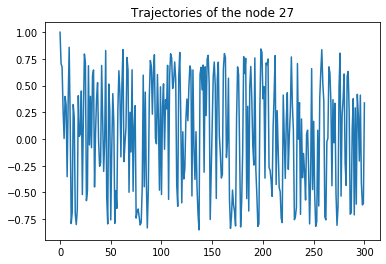

In [21]:
nodes_to_plot = random.sample(range(100),10) #select 10 random nodes
t = np.arange(len(Network.T)+1) #time steps
for node in nodes_to_plot:
    plt.plot(t, Network.trajectories[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

### Periodic sparkling signal <a name="PeriodicSparkling" ></a>

In this experiment, the input will take value 0 for 10 consecutive time steps and, after that, it will take value 1 (spark). This sequence of 11 time steps will be periodically repeated.

In [25]:
Network.u = np.zeros(300)

i = np.arange(1,31)
Network.u[i*10-1] = 1

In [26]:
########################
# Trajectories
########################  
    
Network.trajectories = Network.initial_state
x_prev = Network.initial_state

for n in Network.T:
    x = np.tanh(Network.W_in*Network.u[n]+np.dot(Network.W,x_prev))
    Network.trajectories = np.vstack((Network.trajectories,x))
    x_prev = x

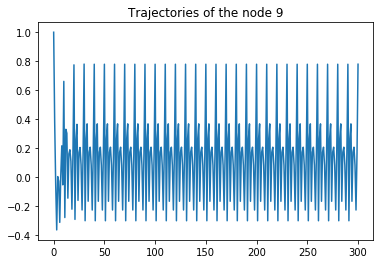

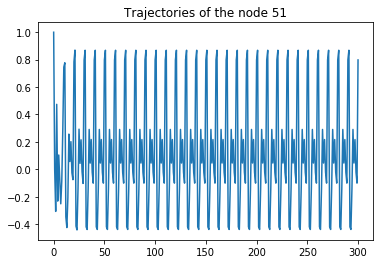

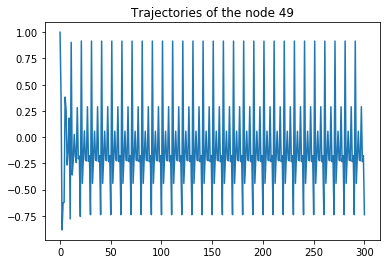

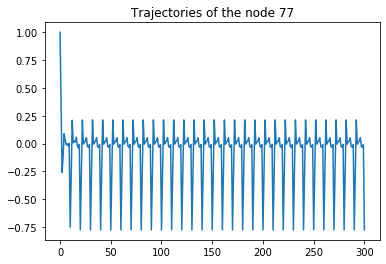

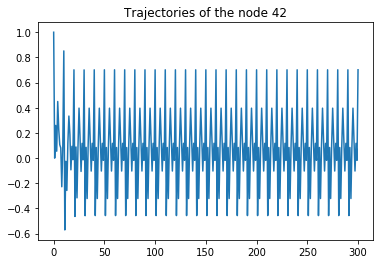

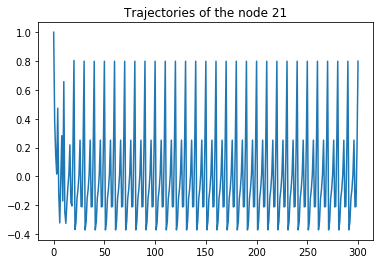

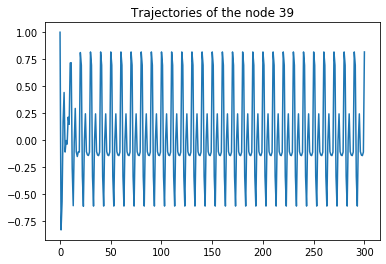

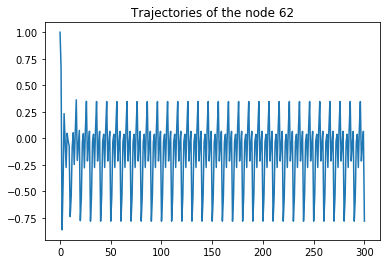

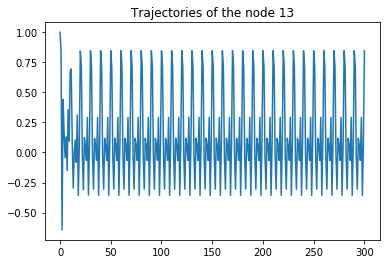

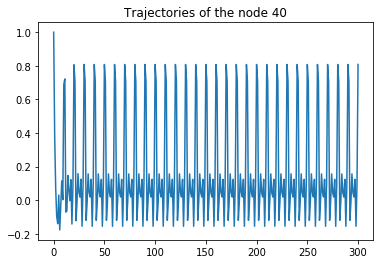

In [27]:
nodes_to_plot = random.sample(range(100),10) #select 5 random nodes
t = np.arange(len(Network.T)+1) #time steps
for node in nodes_to_plot:
    plt.plot(t, Network.trajectories[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

Notice that, as expected, all the trajectories are periodic. On the other hand, notice that in the time between sparks, the values of the nodes are quite small.

### Random sparkling signal <a name="RandomSparkling" ></a>

The input is going to take constant value 0 except for some random time steps, when it will take value 1 (spark).

In [47]:
Network.u = np.zeros(300)

i = random.sample(range(300), 20)
Network.u[i] = 1
print(np.sort(i))

[  1  17  37  42  43  56  89  95 112 113 133 179 197 203 211 233 267 269
 270 277]


In [48]:
########################
# Trajectories
########################  
    
Network.trajectories = Network.initial_state
x_prev = Network.initial_state

for n in Network.T:
    x = np.tanh(Network.W_in*Network.u[n]+np.dot(Network.W,x_prev))
    Network.trajectories = np.vstack((Network.trajectories,x))
    x_prev = x

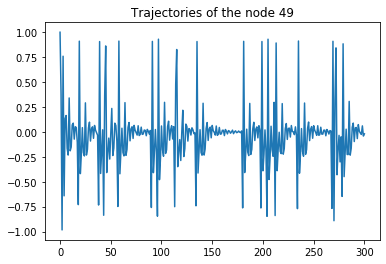

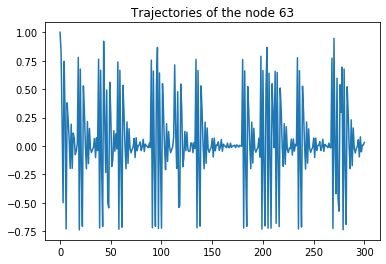

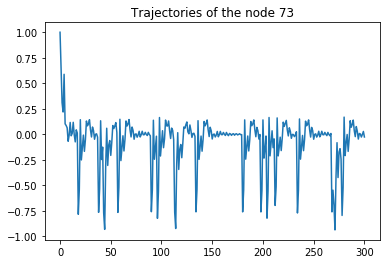

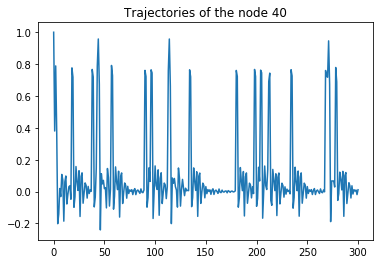

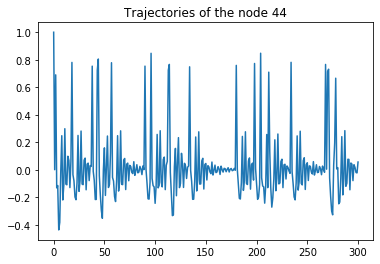

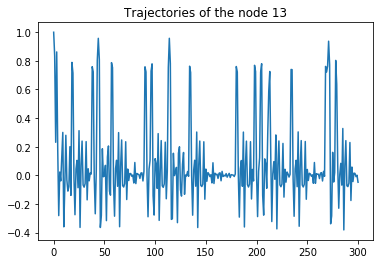

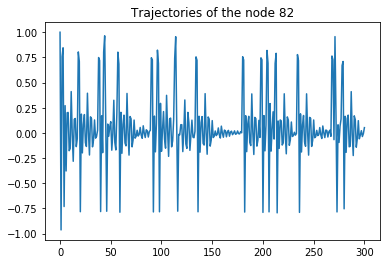

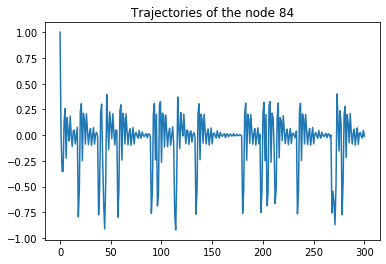

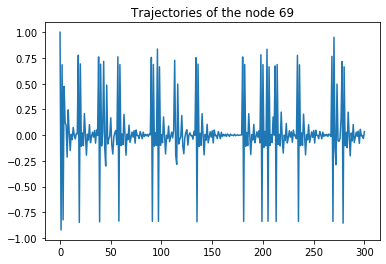

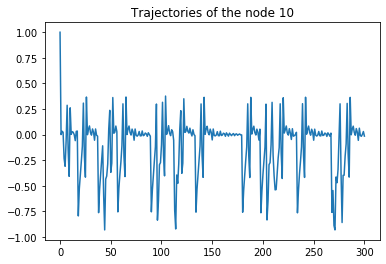

In [49]:
nodes_to_plot = random.sample(range(100),10) #select 10 random nodes
t = np.arange(len(Network.T)+1) #time steps
for node in nodes_to_plot:
    plt.plot(t, Network.trajectories[:,node])  
    plt.title("Trajectories of the node {}".format(node))
    plt.show()

Notice the complex behavior displayed for these trajectories.

# 3. Training a toy problem <a name="ToyProblem" ></a>

In this section, we perform two experiments where we try to learn the output solely from the input (and the reservoir). In the first one, the input is quite simple and the output is very related with the input. On the other hand, in the second one, the input is quite complex and is less related with the output. The reason for the second experiment is to show that this approach does not actually work for all type of problems.

## 3.1 Learning an output with no feedback: input and output related <a name="Related" ></a>

In this section we are going to train a network that inputs
$$
u(n)=\sin\left(\frac{n}{5}\right),
$$
which is an input we already encountered above, so as to learn the output
$$
y_\text{teach}(n)=\frac{1}{2}\sin^7\left(\frac{n}{5}\right).
$$

To clarify notation, $y(n)$ is the output produced by the network at time $n$ whereas $y_\text{teach}(n)$ is the desired output at time $n$.

In order to do so, we are going to use a network without feedback. As already discussed in [Section 2.2](#Homogeneity), it is important to define an inhomogeneous reservoir, since it allows to learn a wider range of dynamics. Therefore, we are going to use the network already defined in [Section 2.1](#StateForgettingProperty). Recall that the reservoir had 100 nodes and its connections had weights 0, -0.4 and 0.4 with probabilities 0.95, 0.025 and 0.025 respectively. The input weights took values -1 and 1 with the same probability. Notice that, in this example, we do not have input but feedback. Finally, all the activation functions ($f$ and $f^\text{out}$) will be tanh. Notice that there we defined that network for 100 time steps. Now, we are going to consider 300 time steps. 

We are going to clean up all the variables and define the network again with some more attributes and methods to the *Network()* class.

In [ ]:
#restart the kernel
import os
os._exit(00)

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy.linalg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
class Network():
    def __init__(self, T = None, n_min = None, K = None, N = None, L = None, W_in = None, W = None,
                 u = None, y_teach = None, initial_state = None, f = None, f_out = None):
        
        #NEED TO BE DEFINED BY THE USER:
        self.T = T #number of training time steps (integer)
        self.n_min = n_min #time steps dismissed (integer)
        
        self.K = K #dimension of the input (integer) (may be None)
        self.N = N #dimension of the reservoir, i.e, number of nodes (integer)
        self.L = L #dimension of the output (integer)
        
        self.W_in = W_in #input connections 
        self.W = W #adjacency matrix (matrix of size self.N x self.N)
        
        self.u = u #input
        self.y_teach = y_teach #desired output of the network
        
        self.initial_state = initial_state #initial state of the reservoir
        self.f = f #activation function of the reservoir
        self.f_out = f_out #activation function of the output
        
        #NOT NEED TO BE DEFINED BY THE USER
        self.trajectories = None #matrix storing the dynamics of the reservoir: columns -> nodes; rows -> time steps
        
        
    
    def dismiss_transient_traj(self):
        self.trajectories = self.trajectories[self.n_min:,:]
        return  self
    
    def dismiss_transient_teach(self):
        self.y_teach = self.y_teach[self.n_min:]
        return self
    
    
    def compute_nodes_trajectories(self): #assumes there are no feedback connections
        self.trajectories = self.initial_state
        x_prev = self.initial_state

        for n in np.arange(self.T):
            x = np.tanh(np.dot(self.W_in,self.u[n])+np.dot(self.W,x_prev))
            self.trajectories = np.vstack((self.trajectories,x))
            x_prev = x
            
        self.trajectories = self.trajectories[1:,:]
        
        return self
    
    
    def plot_nodes_trajectories(self, sel_nodes=False, num_nodes=10):
        if sel_nodes == False:
            nodes_to_plot = random.sample(range(self.N),num_nodes) #select num_nodes random nodes
        else:
            nodes_to_plot = sel_nodes
        
        t = np.arange(self.T) #time steps
        for node in nodes_to_plot:
            plt.plot(t, self.trajectories[:,node])  
            plt.title("Trajectories of the node {}".format(node))
            plt.show()

### 3.1.1 Definition of the parameters of the network <a name="Ex1Params" ></a>

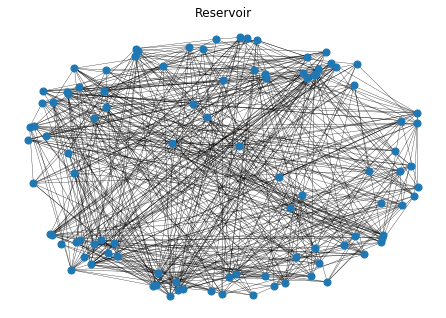

The reservoir has 100 nodes and 520 edges


In [3]:
########################
# Initialize instance
########################
Network = Network()

########################
# Define the parameters
########################

Network.T = 300
Network.n_min = 100
Network.K = 1
Network.N = 100
Network.L = 1

Network.u = np.sin(np.arange(Network.T)/5)
Network.y_teach = 0.5*Network.u**7

Network.f = "tanh"
Network.f_out = "tanh"
Network.initial_state = np.ones(Network.N)


Network.W_in = random.choices([-1,1], k=Network.N*Network.K)
Network.W_in = np.asarray(Network.W_in)



########################
# Reservoir
########################

Network.W = np.zeros([Network.N,Network.N]) #adjacency matrix

for i in np.arange(Network.N):
    for j in np.arange(Network.N):
        p = np.random.uniform()
        if 0<= p <0.025:
            Network.W[i,j] = 0.4            
            
        elif 0.025 <= p <0.05:
            Network.W[i,j] = -0.4
            

G=nx.from_numpy_matrix(Network.W)
nx.draw(G, pos=nx.spring_layout(G), width = 0.3, node_size=50)
plt.title('Reservoir')
plt.show()

print('The reservoir has {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))            


Let us now compute the trajectories of each node and plot them for ten randomly selected nodes.

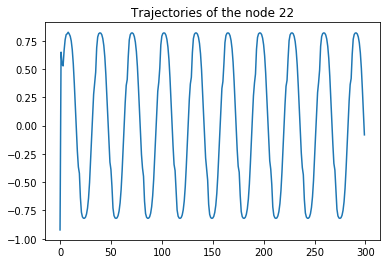

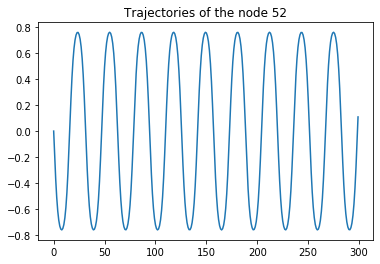

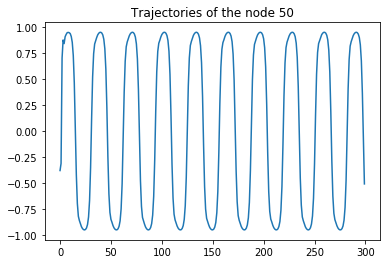

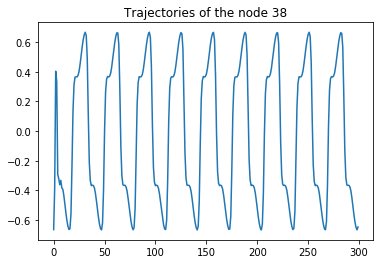

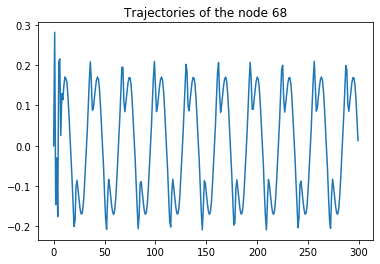

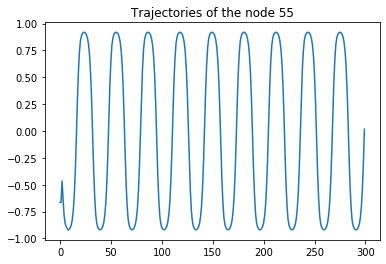

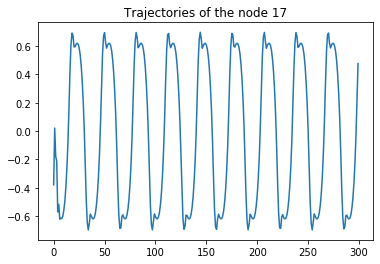

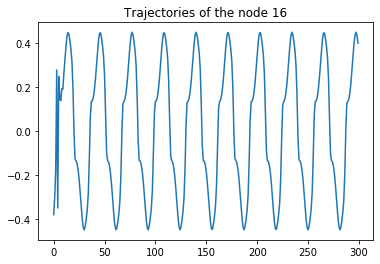

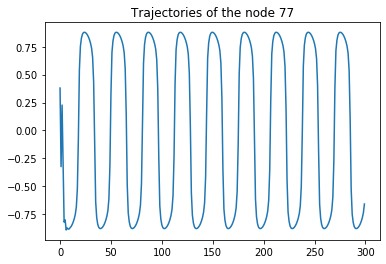

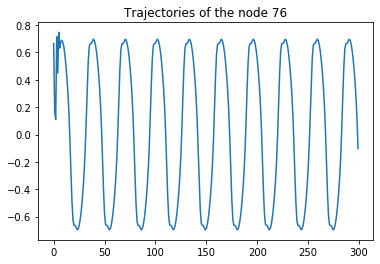

In [4]:
Network.compute_nodes_trajectories()
Network.plot_nodes_trajectories()

Let us now dismiss a transient of 100 time steps. This is done so as to remove the initial state influence (state forgetting property).

In [5]:
Network.dismiss_transient_traj()
Network.dismiss_transient_teach()

In [6]:
print(Network.trajectories.shape)
print(Network.y_teach.shape)

(200, 100)
(200,)


### 3.1.2 Training <a name="Ex1Train" ></a>

Since we do not have feedback, the update of the internal states will be given by

$$
x(n+1)=\tanh(W^\text{in} u(n+1)+Wx(n)).
$$

This information is going to be stored in the *trajectories* attribute of the instance *Network*, which is going to be redefined in the following cell. Then, the output is going to be computed as

$$
y(n+1)=\tanh(W^\text{out}x(n+1)).
$$

This is going to be stored in the $y$ attribute of the instance *Network*. The accuracy of the training is going to be measured by means of the MSE, which is computed as follows

$$
\text{MSE}_\text{train}=\frac{1}{n_\text{max}-n_\text{min}}\sum_{n=n_\text{min},...,n_\text{max}}\epsilon^2_\text{train}(n),
$$

where

$$
\epsilon_\text{train}(n) = \text{tanh}^{-1}y_\text{teach}(n)-\text{tanh}^{-1}y(n).
$$


In [7]:
regressor = LinearRegression()  
regressor.fit(Network.trajectories, np.arctanh(Network.y_teach))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
print("The training MSE is {}".format(mean_squared_error(np.arctanh(Network.y_teach), regressor.predict(Network.trajectories))))

The training MSE is 3.186652524695669e-24


### 3.1.3 Testing <a name="Ex1Test" ></a>

In the testing steps, the update of the reservoir is going to be performed the same way as in the training. That is,

$$
x(n+1)=\tanh(W^\text{in} u(n+1)+Wx(n)).
$$

Then, the output of the network is given by 

$$
y(n)= \tanh(W^\text{out}x(n)),
$$

where $W^\text{out}$ was learnt during the training. 

As shown in [Section 3.1.2](#Ex1Train), the accuracy is measured by the MSE.

Recall that we trained the network using the time steps $n\in\{99,...,299\}$ (since a dismissal of the first 100 steps was performed). Then, we are going to test the network for $n\in\{300,...,600\}$.

In [10]:
#input vector for the test
input_vector = np.sin(np.arange(300,600)/5)
y_ground_truth = 0.5*input_vector**7

#computing the trajectories of the reservoir
trajectories = Network.trajectories[-1,:]
x_prev = Network.trajectories[-1,:]

for n in np.arange(len(input_vector)):
    x = np.tanh(np.dot(Network.W_in, input_vector[n])+np.dot(Network.W,x_prev))
    trajectories = np.vstack((trajectories,x))
    x_prev = x
    
#predict
y_pred = np.tanh(regressor.predict(trajectories))
print("The test MSE is {}".format(mean_squared_error(np.arctanh(y_ground_truth), y_pred[1:])))

The test MSE is 0.0002824189907180255


<function matplotlib.pyplot.show(*args, **kw)>

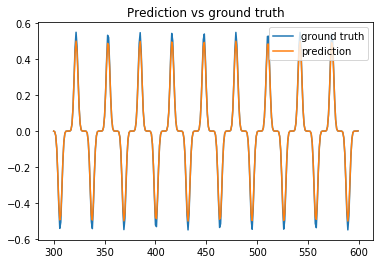

In [17]:
plt.plot(np.arange(300,600), np.arctanh(y_ground_truth), label='ground truth')
plt.plot(np.arange(300,600), y_pred[1:], label='prediction')
plt.legend()
plt.title('Prediction vs ground truth')
plt.show

We obtained a testing MSE of 2.8e-4, which is very low. Therefore, when plotting the predictions against the true values, we see that both lines almost coincide.

## 3.2 Learning an output with no feedback: input and output non-related <a name="NonRelated" ></a>

In [Section 3.1](#Related), we learnt an output solely from the input (and the internal states of the reservoir). In that case, the output to be learnt was the input to the 7th power divided by 2. Therefore, the output and the input were related. In addition, the input was quite simple. Let us now see if it is also possible to learn an output from a less related and more complex input by means of this simple approach.

We are going to train a network that inputs

$$
u(n) = \frac{1}{20}\left(\sin\left(\frac{n}{10}\right)+7\sin\left(\frac{n}{3}\right)+\sin(3n)\cos(n)\right)
$$

so as to learn the output

$$
y_\text{teach}(n)= \frac{1}{15}\left|\sin\left(\frac{n}{10}\right)+7\sin\left(\frac{n}{3}\right)+\sin(3n)\cos(n)\right|+\frac{1}{\pi}\cos\left(\frac{n}{5}\right)
$$

In order to do so, we are going to use the same reservoir and procedure as in [Section 3.1](#Related). So, see that Section for the details of the training and testing procedures (formulas).

### 3.2.1 Definition of the parameters of the network <a name="Ex2Params" ></a>

In [11]:
Network2 = Network

#input
Network2.u = (np.sin(np.arange(Network.T)/10)+7*np.sin(np.arange(Network.T)/3)+np.sin(3*np.arange(Network.T))*np.cos(np.arange(Network.T)))/20

#desired output
Network2.y_teach = 1/15*abs(Network2.u)+1/np.pi*np.cos(np.arange(Network.T)/5)

#Compute the new trajectories
Network2.compute_nodes_trajectories()

#dismiss transient
Network2.dismiss_transient_traj()
Network2.dismiss_transient_teach()

### 3.2.2 Training <a name="Ex2Train" ></a>

In [12]:
regressor2 = LinearRegression()  
regressor2.fit(Network2.trajectories, np.arctanh(Network2.y_teach))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
print("The training MSE is {}".format(mean_squared_error(np.arctanh(Network2.y_teach), regressor2.predict(Network2.trajectories))))

The training MSE is 0.04101427623702042


### 3.2.3 Testing <a name="Ex2Test" ></a>

Since the training has been done for time steps $n\in\{99,...,299\}$ (since a dismissal of the first 100 steps was performed). Then, we are going to test the network for $n\in\{300,...,600\}$.

In [21]:
#input vector for the test
input_vector = (np.sin(np.arange(300,600)/10)+7*np.sin(np.arange(300,600)/3)+np.sin(3*np.arange(300,600))*np.cos(np.arange(300,600)))/20
y_ground_truth = 1/15*abs(input_vector)+1/np.pi*np.cos(np.arange(300,600)/5)

#computing the trajectories of the reservoir
trajectories = Network2.trajectories[-1,:]
x_prev = Network2.trajectories[-1,:]

for n in np.arange(len(input_vector)):
    x = np.tanh(np.dot(Network2.W_in, input_vector[n])+np.dot(Network2.W,x_prev))
    trajectories = np.vstack((trajectories,x))
    x_prev = x
    
#predict
y_pred = np.tanh(regressor.predict(trajectories))
print("The test MSE is {}".format(mean_squared_error(np.arctanh(y_ground_truth), y_pred[1:])))

The test MSE is 0.7425177770893923


<function matplotlib.pyplot.show(*args, **kw)>

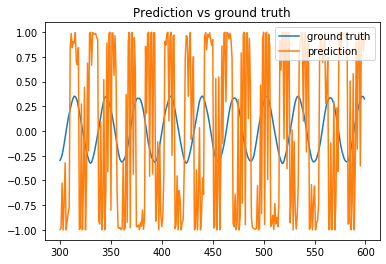

In [23]:
plt.plot(np.arange(300,600), np.arctanh(y_ground_truth), label='ground truth')
plt.plot(np.arange(300,600), y_pred[1:], label='prediction')
plt.legend(loc='upper right')
plt.title('Prediction vs ground truth')
plt.show

It is clear that, at this case, the predictions do not correspond, by far, to the true values. In fact, what is happening is that the predictions of the network are large in module and, after the tanh is applied, such values are collapsed to 1 and -1.